In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder
import scipy
import itertools
from sklearn.feature_extraction.text import CountVectorizer
import unicodedata, re, string
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer


## Nacitanie

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_3.csv')

## Rozdelenie dat na sady

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(X_train[:10])

391     hatred cast thought reach sea many blossoms op...
1518    niece sir w batten come great content without ...
95      stayed day without food drink follering came d...
1072    afterward bunny brown sister sue learned goat ...
760     daur ye speyk gait aboot yer sonay mine mair g...
1312    twice began-twice voice failed last words came...
1280    immense ruin spot earth man feels significance...
465     half dozen pounds tea weigh couple bottles spi...
601     admiral curling whiskers sent castle inquire b...
903     natives believe lighted tar-barrels cordon san...
Name: processed_text, dtype: object


## One hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
print(y_valid)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


# CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
X_train_cv = vectorizer.fit_transform(X_train).toarray()
X_test_cv = vectorizer.transform(X_test).toarray()
X_valid_cv = vectorizer.transform(X_valid).toarray()


In [ ]:
y_train.shape

(1404, 20)

## Model 1

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train_cv.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               49094144  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
# Train the model
history = model.fit(X_train_cv, y_train, validation_data=(X_valid_cv, y_valid), epochs=15, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/15
176/176 [==============================] - 9s 28ms/step - loss: 1.9821 - accuracy: 0.5335 - val_loss: 0.4366 - val_accuracy: 0.9103
Epoch 2/15
176/176 [==============================] - 5s 29ms/step - loss: 0.5096 - accuracy: 0.8882 - val_loss: 0.2172 - val_accuracy: 0.9551
Epoch 3/15
176/176 [==============================] - 3s 18ms/step - loss: 0.3916 - accuracy: 0.9217 - val_loss: 0.2561 - val_accuracy: 0.9295
Epoch 4/15
176/176 [==============================] - 5s 27ms/step - loss: 0.2222 - accuracy: 0.9630 - val_loss: 0.1847 - val_accuracy: 0.9679
Epoch 5/15
176/176 [==============================] - 5s 29ms/step - loss: 0.0718 - accuracy: 0.9879 - val_loss: 0.1042 - val_accuracy: 0.9872
Epoch 6/15
176/176 [==============================] - 3s 18ms/step - loss: 0.1074 - accuracy: 0.9865 - val_loss: 0.1300 - val_accuracy: 0.9744
Epoch 7/15
176/176 [==============================] - 3s 18ms/step - loss: 0.1175 - accuracy: 0.9786 - val_loss: 0.3277 - val_accuracy: 0.9487

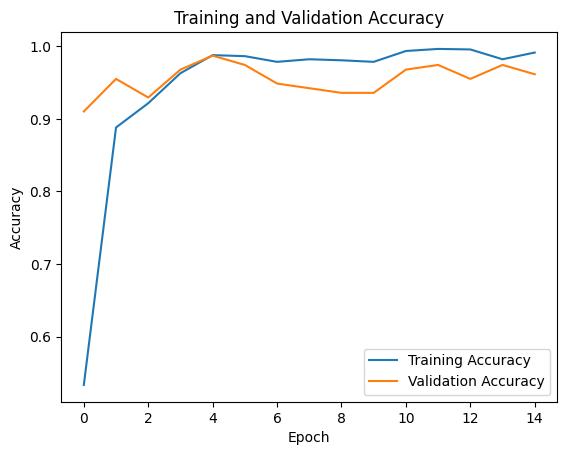

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_cv, y_test, verbose=0)

y_pred_probs = model.predict(X_test_cv)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

test_f1 = f1_score(y_test_indices, y_pred, average='macro')
test_precision = precision_score(y_test_indices, y_pred, average='macro')
test_recall = recall_score(y_test_indices, y_pred, average='macro')

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

13/13 [==============================] - 0s 9ms/step
Test loss: 0.12407483160495758
Test accuracy: 0.971867024898529
Test F1 Score: 0.9634978841194674
Test Precision: 0.967024720893142
Test Recall: 0.9619356155540364


# TextVectorization

## Model 2


In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
model = tf.keras.Sequential([
    vect_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 6000, 256)         15360000  
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/15
176/176 [==============================] - 23s 116ms/step - loss: 2.7584 - accuracy: 0.1503 - val_loss: 2.4446 - val_accuracy: 0.2821
Epoch 2/15
176/176 [==============================] - 19s 108ms/step - loss: 1.9201 - accuracy: 0.3925 - val_loss: 1.5394 - val_accuracy: 0.4744
Epoch 3/15
176/176 [==============================] - 18s 104ms/step - loss: 1.2694 - accuracy: 0.5691 - val_loss: 1.0173 - val_accuracy: 0.6923
Epoch 4/15
176/176 [==============================] - 18s 103ms/step - loss: 0.8065 - accuracy: 0.7521 - val_loss: 0.7023 - val_accuracy: 0.8141
Epoch 5/15
176/176 [==============================] - 16s 93ms/step - loss: 0.5186 - accuracy: 0.8575 - val_loss: 0.4913 - val_accuracy: 0.8846
Epoch 6/15
176/176 [==============================] - 17s 94ms/step - loss: 0.3732 - accuracy: 0.8917 - val_loss: 0.3436 - val_accuracy: 0.9231
Epoch 7/15
176/176 [==============================] - 17s 94ms/step - loss: 0.2652 - accuracy: 0.9330 - val_loss: 0.2836 - val_accur

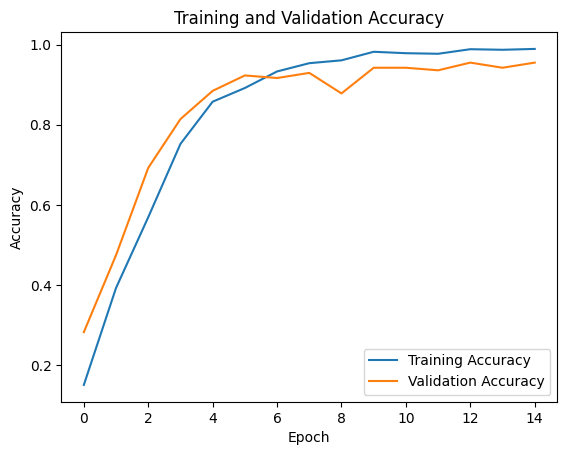

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

13/13 [==============================] - 1s 34ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted')
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.9641943734015346
F1 Score: 0.9642551548229692
Precision: 0.9672359193755866
Recall: 0.9641943734015346


## Model 2 - vacsi vocab_site


In [ ]:
embedding_dim = 512
vocab_size = 90000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
model = tf.keras.Sequential([
    vect_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 6000)              0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 6000, 512)         46080000  
                                                                 
 global_average_pooling1d_1  (None, 512)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)               

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/15
176/176 [==============================] - 25s 134ms/step - loss: 2.7350 - accuracy: 0.1688 - val_loss: 2.4103 - val_accuracy: 0.2692
Epoch 2/15
176/176 [==============================] - 21s 119ms/step - loss: 1.8299 - accuracy: 0.4145 - val_loss: 1.4452 - val_accuracy: 0.5449
Epoch 3/15
176/176 [==============================] - 21s 121ms/step - loss: 1.1112 - accuracy: 0.6595 - val_loss: 0.9361 - val_accuracy: 0.7244
Epoch 4/15
176/176 [==============================] - 20s 116ms/step - loss: 0.7182 - accuracy: 0.7714 - val_loss: 0.6250 - val_accuracy: 0.8397
Epoch 5/15
176/176 [==============================] - 19s 108ms/step - loss: 0.4943 - accuracy: 0.8632 - val_loss: 0.4992 - val_accuracy: 0.8590
Epoch 6/15
176/176 [==============================] - 19s 107ms/step - loss: 0.3189 - accuracy: 0.9117 - val_loss: 0.3575 - val_accuracy: 0.8846
Epoch 7/15
176/176 [==============================] - 18s 104ms/step - loss: 0.2155 - accuracy: 0.9430 - val_loss: 0.3067 - val_ac

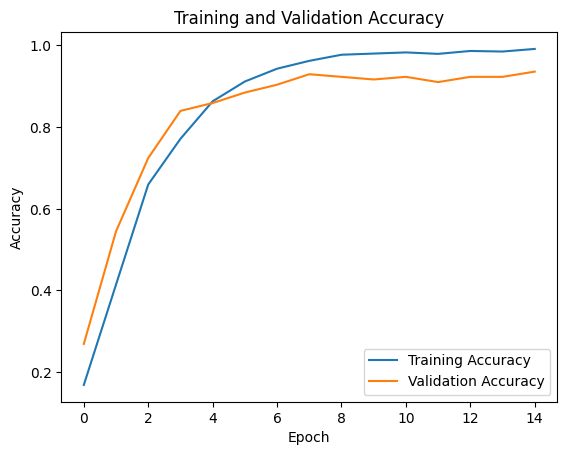

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

13/13 [==============================] - 1s 34ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted')
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.9514066496163683
F1 Score: 0.9547466183041914
Precision: 0.9681465924504655
Recall: 0.9514066496163683
